In [1]:
%matplotlib notebook

# Support Vector Machines

Taken from: https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html

In [2]:
# Algunas dependencias a utilizar

# !pip install seaborn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [4]:
# Configuración

colormap=plt.cm.Paired
dotsize=30

### Generemos datos por ahora linealmente separables

<IPython.core.display.Javascript object>


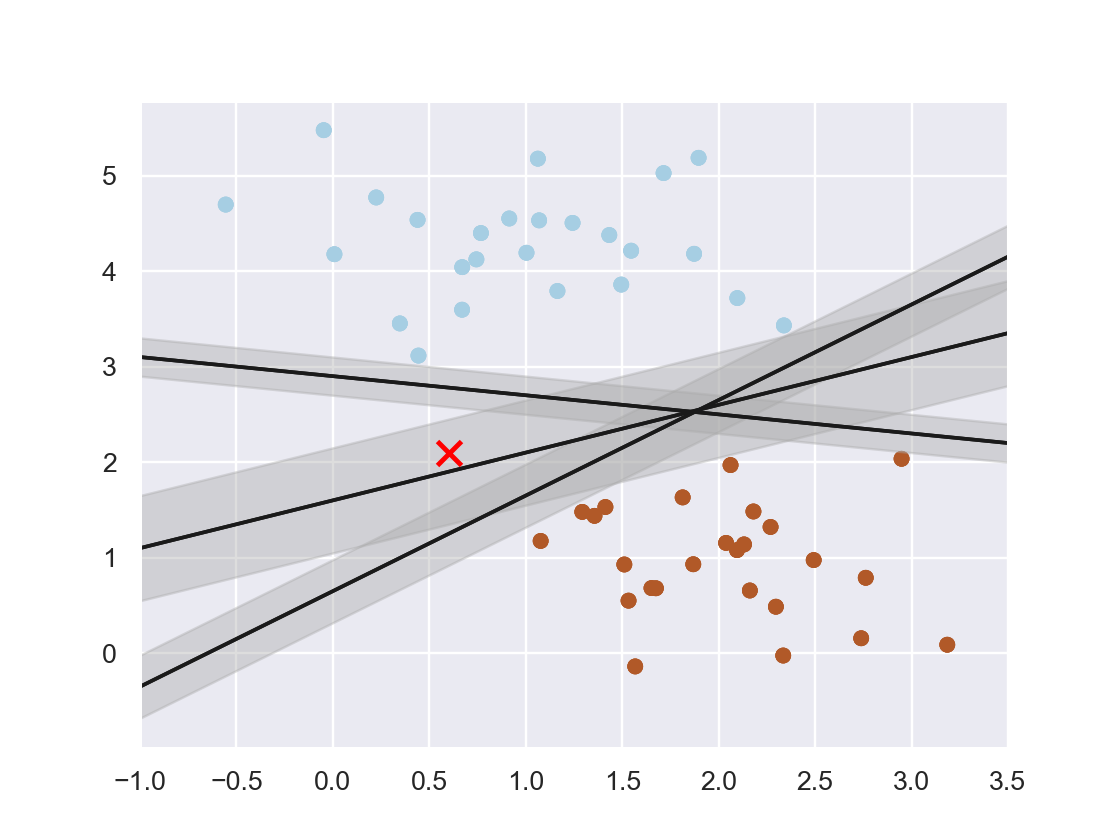

In [5]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap);

¿Qué son las líneas discriminadoras?

In [6]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Maximizando el margen

In [7]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

### Support Vector Classifier

In [8]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

In [9]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    
    # Check https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='k');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

<IPython.core.display.Javascript object>


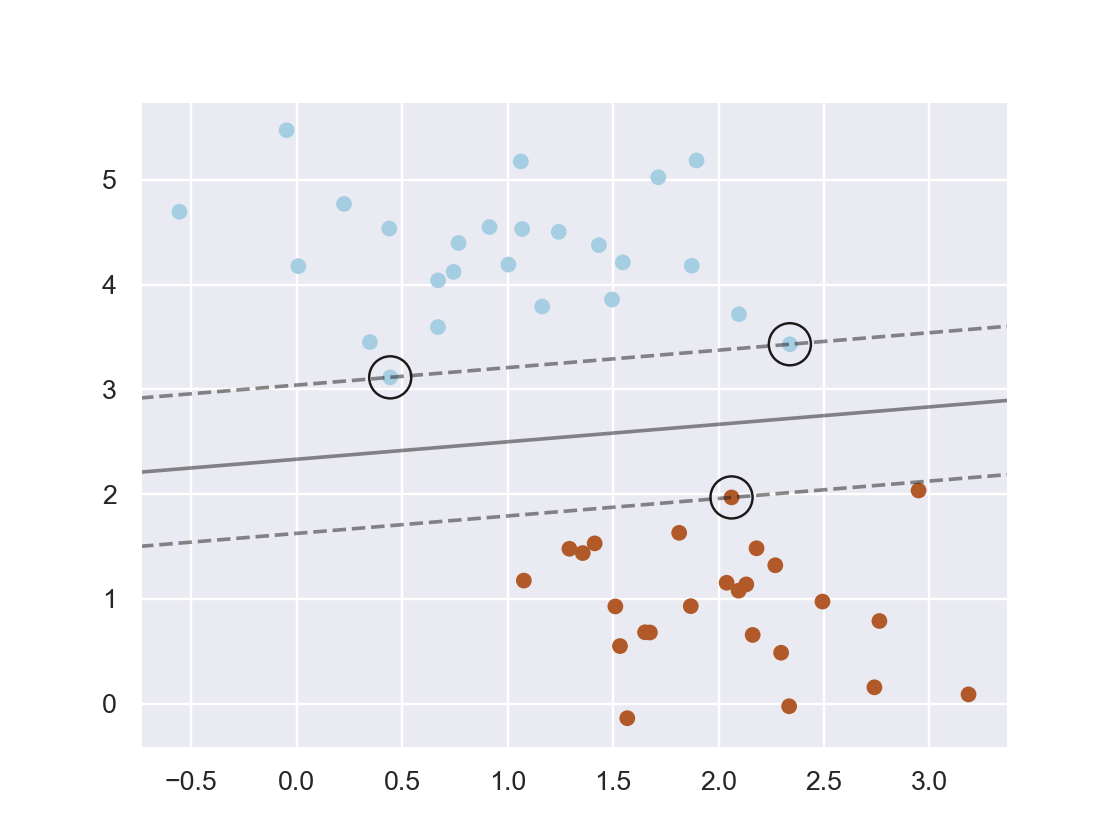

In [10]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
plot_svc_decision_function(model);

¿Dónde están los vectores de soporte?

In [11]:
print(model.support_vectors_)

[[0.44359863 3.11530945]
 [2.33812285 3.43116792]
 [2.06156753 1.96918596]]


## Tarea

¿Cuáles son los coeficientes $\alpha_i$ asociados a los vectores de soporte y los otros puntos?

Una de las claves del éxito de este clasificador es que, para el ajuste, sólo importa la posición de los vectores de soporte; ¡los puntos más alejados del margen que estén en el lado correcto no modifican el ajuste! Técnicamente, esto se debe a que estos puntos no contribuyen a la función de pérdida utilizada para ajustar el modelo, por lo que su posición y número no importan mientras no crucen el margen.

Podemos ver esto, por ejemplo, si trazamos el modelo aprendido a partir de los primeros 60 puntos y los primeros 120 puntos de este conjunto de datos:

<IPython.core.display.Javascript object>


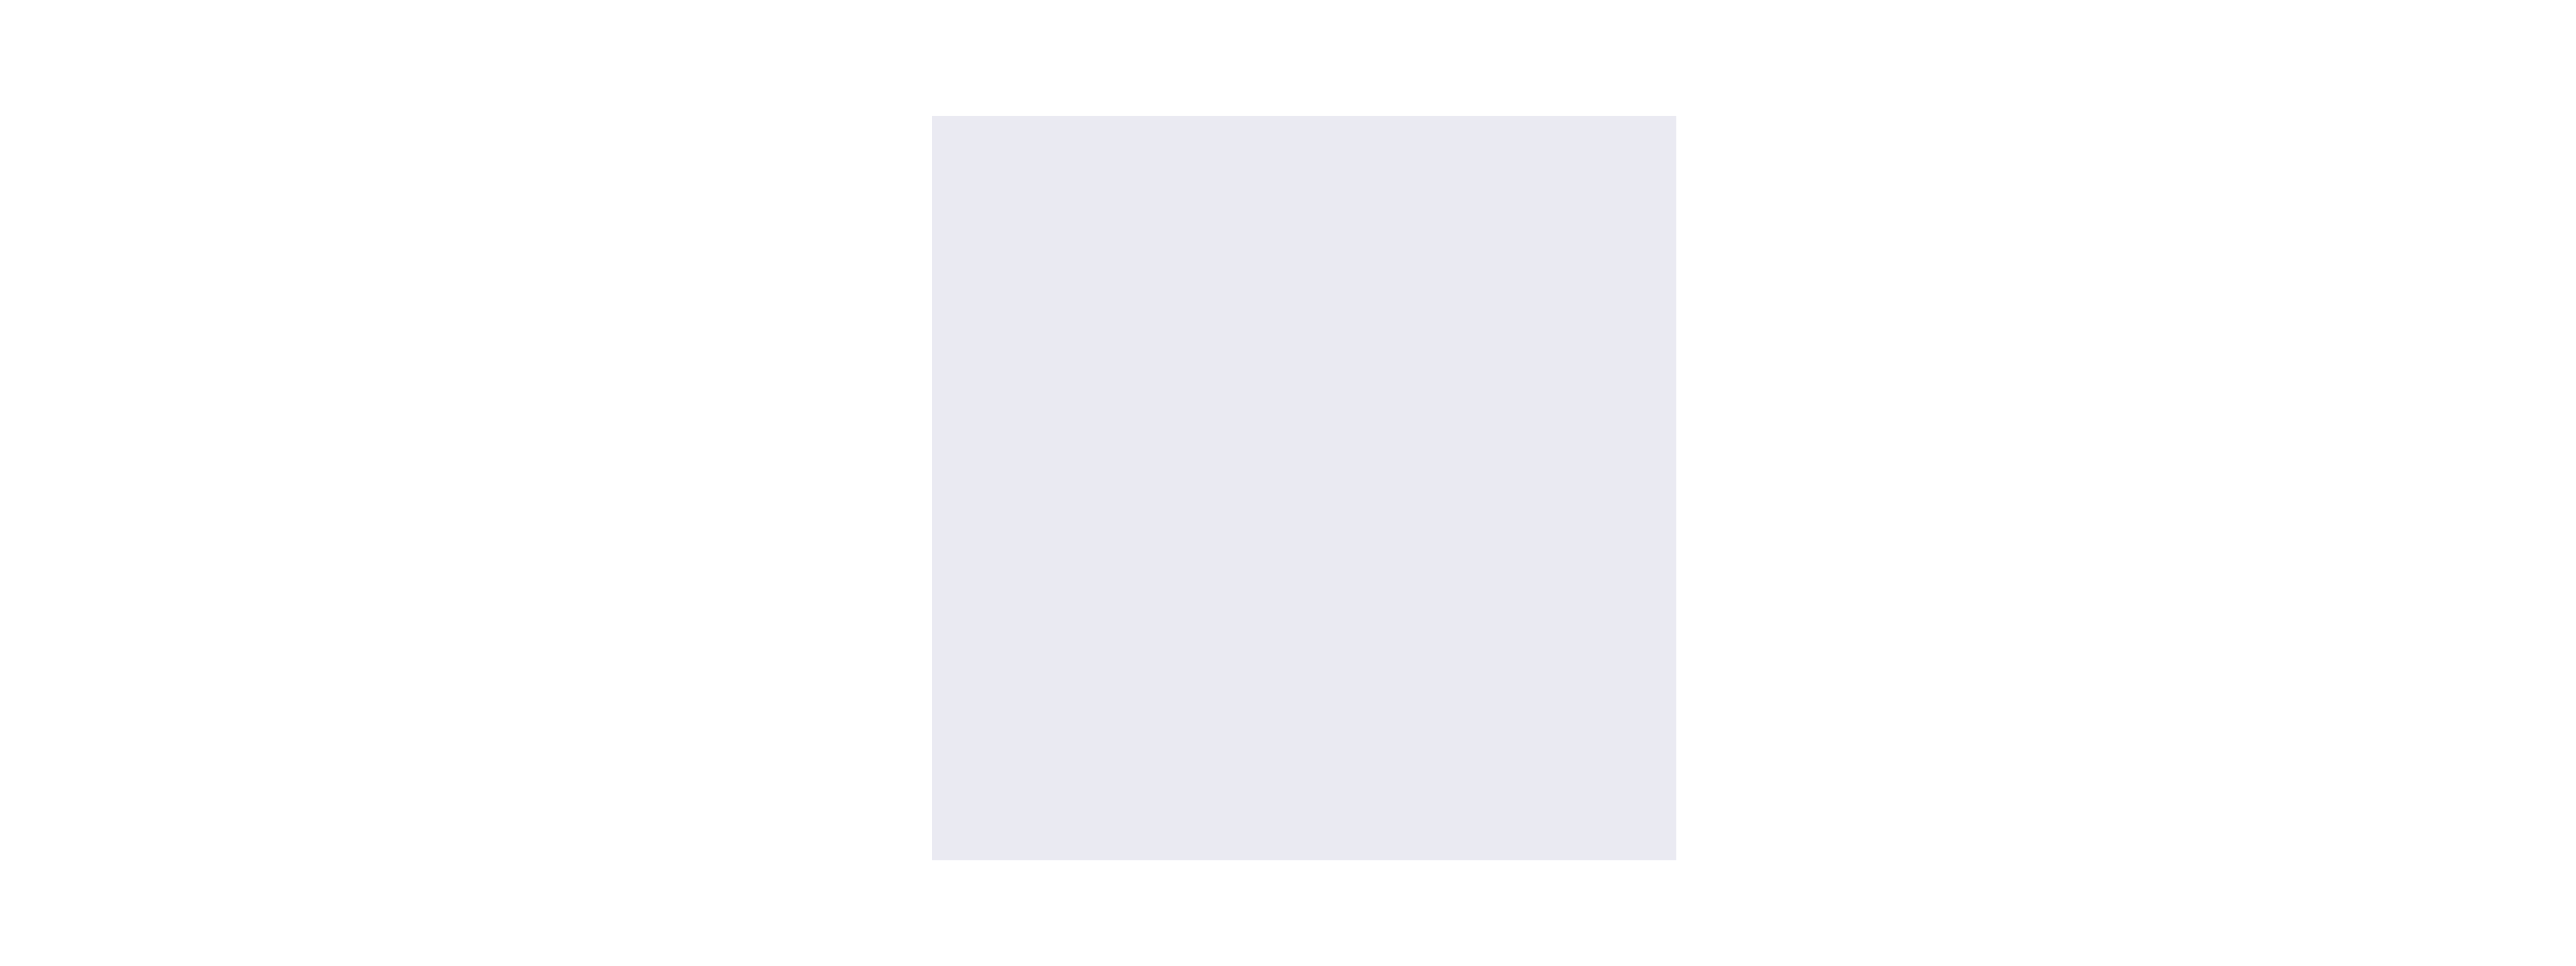

In [12]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

En el panel de la izquierda, vemos el modelo y los vectores de soporte para 60 puntos de entrenamiento. En el panel de la derecha, se ha duplicado el número de puntos de entrenamiento, pero el modelo no ha cambiado: los tres vectores de soporte del panel de la izquierda siguen siendo los vectores de apoyo del panel de la derecha. Esta insensibilidad al comportamiento exacto de los puntos distantes es uno de los puntos fuertes del modelo SVM.

En el siguiente ejemplo se puede jugar interactivamente con el número de puntos.  Observe con detenimiento el comportamiento de los vectores de soporte.

In [13]:
from ipywidgets import interact, fixed
interact(plot_svm, N=(10,200), ax=fixed(None));

interactive(children=(IntSlider(value=10, description='N', max=200, min=10), Output()), _dom_classes=('widget-…

### Más allá de fronteras lineales

Donde la SVM se vuelve extremadamente potente es cuando se combina con kernels.

Para motivar la necesidad de los núcleos, veamos algunos datos que no son linealmente separables:


In [14]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
plot_svc_decision_function(clf, plot_support=False);

Pensemos en cómo podríamos proyectar los datos en una dimensión superior, de forma que un separador lineal fuera suficiente. Por ejemplo, una proyección sencilla que podríamos utilizar sería calcular una función de base radial centrada en el grupo central:

In [15]:
r = np.exp(-(X ** 2).sum(1))

In [16]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=dotsize, cmap=colormap)
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=(-90, 90), azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(IntSlider(value=30, description='elev', max=90, min=-90), IntSlider(value=30, descriptio…

In [17]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### Suavizando los márgenes

Hasta ahora nos hemos centrado en conjuntos de datos muy limpios, en los que existe una frontera de decisión perfecta. Pero, ¿qué ocurre si sus datos tienen algún tipo de solapamiento? Por ejemplo, puede tener datos como estos:

In [19]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap);

Para manejar este caso, la implementación de SVM usa los factores de holgura que "suavizan" el margen: es decir, permite que algunos de los puntos se pasen del margen si eso permite un mejor ajuste. La dureza del margen se controla mediante un parámetro de ajuste, conocido a menudo como C. Para C muy grande, el margen es duro, y los puntos no pueden estar en él. Para un C más pequeño, el margen es más suave y puede crecer hasta abarcar algunos puntos.

El gráfico que se muestra a continuación ofrece una imagen visual de cómo un parámetro C cambiante afecta al ajuste final, a través de la suavización del margen:

<IPython.core.display.Javascript object>


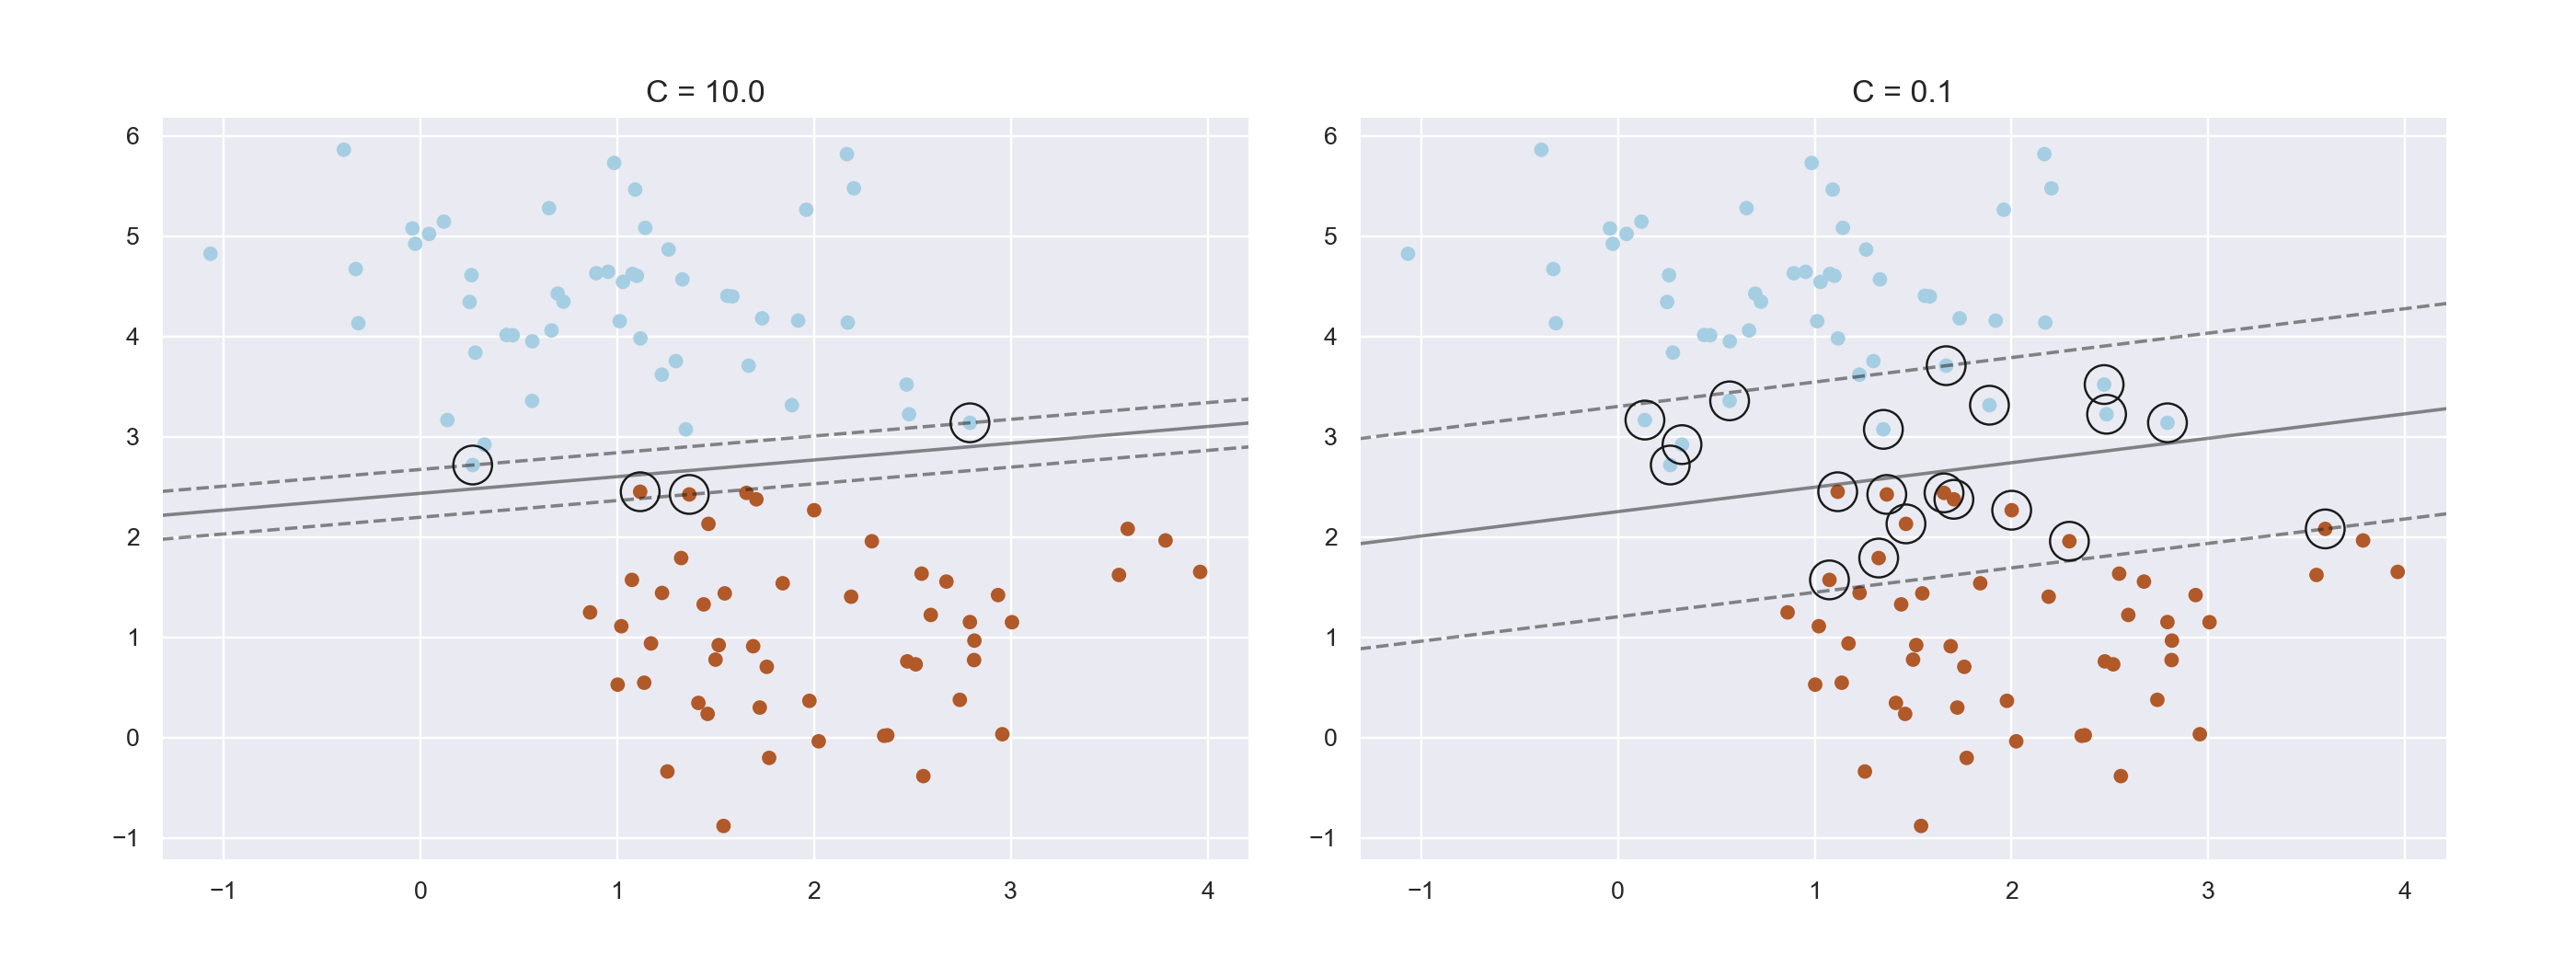

In [20]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=dotsize, cmap=colormap)
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

# Ejemplo: Reconocimiento de caras

In [21]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


<IPython.core.display.Javascript object>


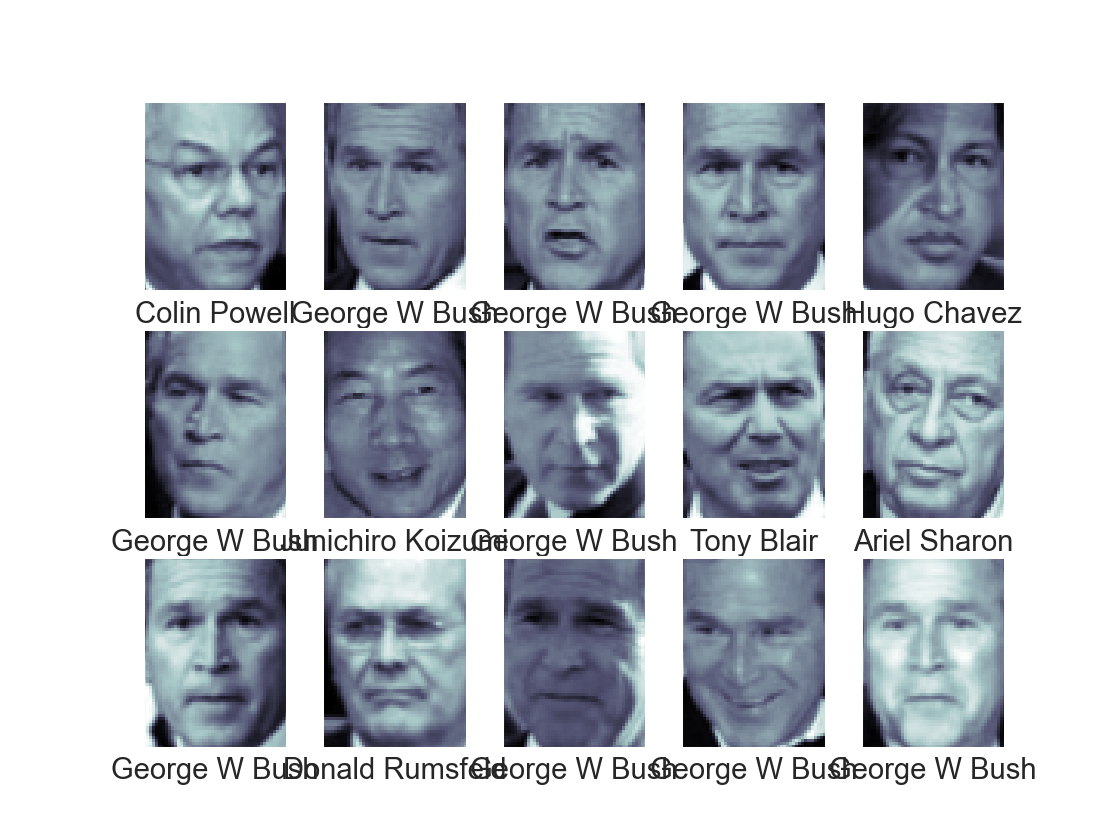

In [22]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Cada imagen tiene 62×47 pixeles (casi 3000 px). Podríamos proceder simplemente utilizando el valor de cada píxel como una característica, pero a menudo es más eficaz utilizar algún tipo de preprocesador para extraer características más significativas; aquí utilizaremos un análisis de componentes principales, (aunque veremos después no es tan recomendable...) para extraer 150 componentes fundamentales para alimentar nuestro clasificador de máquina de vectores de soporte. 

Podemos hacer esto de manera más directa empaquetando el preprocesador y el clasificador en una sola tubería:


In [23]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

pca = PCA(n_components=150, svd_solver='randomized',whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [24]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

In [25]:
from sklearn.model_selection import GridSearchCV

# Como tenemos un pipeline, tenemos que indicar a qué objeto pertenece el 
# parámetro (svc__ o pca__)
param_grid = [{'svc__C': [0.1,1, 5], 
               'svc__kernel': ['poly'],'svc__degree': [3,4,5],'svc__gamma': [0.01,0.1,1], 'svc__coef0':[0,0.1,1]},
              {'svc__C': [0.1,1, 5], 
               'svc__kernel': ['sigmoid'],'svc__gamma': [0.01,0.1,1], 'svc__coef0':[0,0.1,1]}]
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)

CPU times: user 10min 27s, sys: 12.4 s, total: 10min 39s
Wall time: 1min 47s
{'svc__C': 0.1, 'svc__coef0': 1, 'svc__degree': 3, 'svc__gamma': 0.01, 'svc__kernel': 'poly'}


In [26]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

<IPython.core.display.Javascript object>


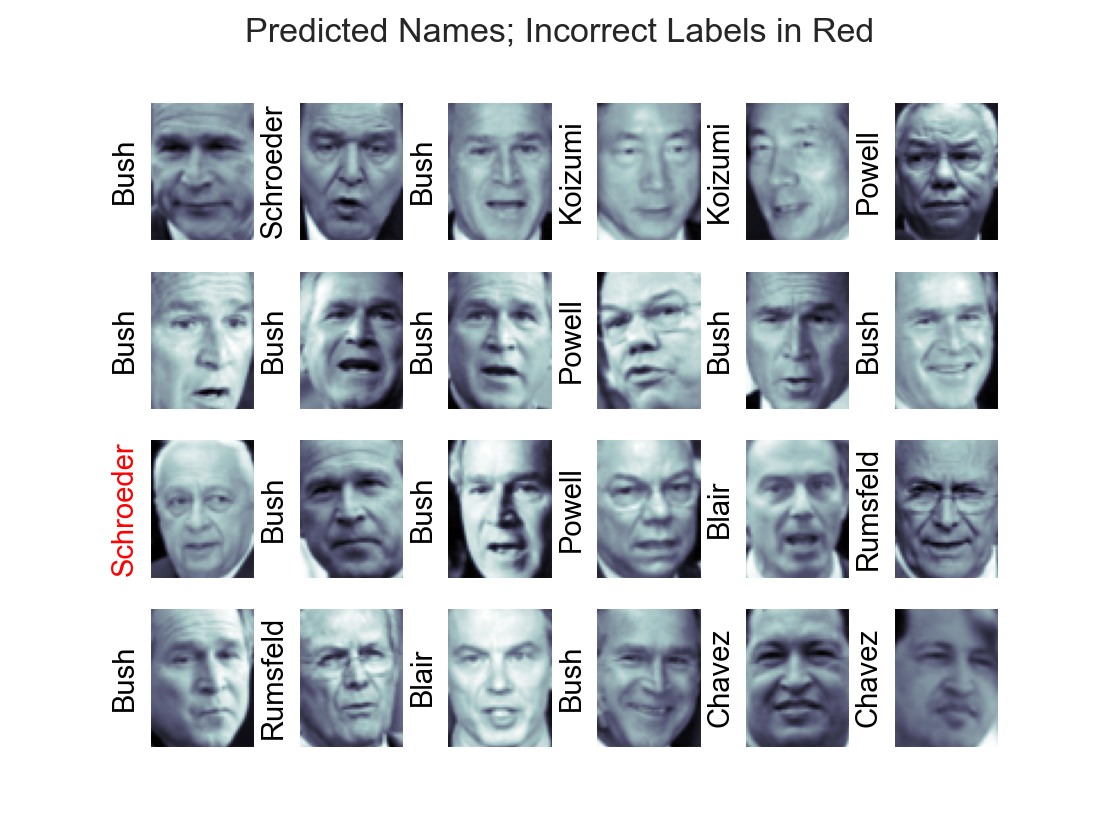

In [27]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [28]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.82      0.60      0.69        15
     Colin Powell       0.90      0.90      0.90        68
  Donald Rumsfeld       0.79      0.74      0.77        31
    George W Bush       0.85      0.93      0.89       126
Gerhard Schroeder       0.86      0.83      0.84        23
      Hugo Chavez       1.00      0.70      0.82        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.84      0.90      0.87        42

         accuracy                           0.87       337
        macro avg       0.88      0.81      0.84       337
     weighted avg       0.87      0.87      0.86       337



<IPython.core.display.Javascript object>


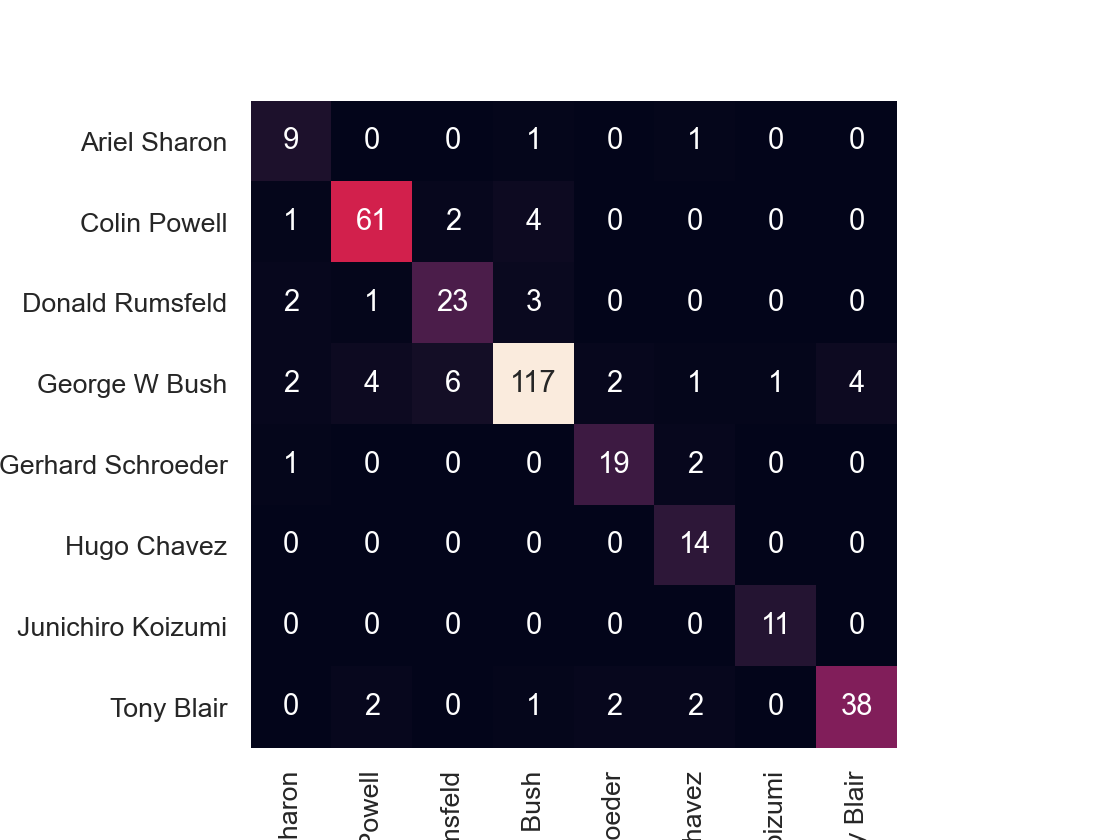

In [29]:
from sklearn.metrics import confusion_matrix
plt.figure();
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');